In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

### classifier - generated with maxp/shape/entropy features

In [3]:
mm.run.max()

9

In [4]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [5]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

13

In [6]:
mm.shape

(12909627, 20)

In [7]:
%%time

mmg = mm[mm.segment=='generated']

df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

df_logitlens_iou_expanded = mmg['logitlens_iou'].apply(pd.Series)
df_logitlens_iou_expanded.columns = [f'logitlens_iou{i}' for i in range(df_logitlens_iou_expanded.shape[1])]

# concat with the original
mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                     df_logitlens_kl_expanded,
                     df_logitlens_iou_expanded], axis=1)

CPU times: user 16.1 s, sys: 281 ms, total: 16.4 s
Wall time: 16.4 s


In [8]:
mmg.shape

(126207, 82)

In [9]:
%%time

# beginning of generation
N = 10

selected_features = ['shape', 'true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

CPU times: user 21.8 ms, sys: 5.62 ms, total: 27.4 ms
Wall time: 26.5 ms


In [10]:
ds.correct.value_counts()

correct
True     3702
False    1418
Name: count, dtype: int64

In [11]:
ds.shape

(5120, 34)

In [12]:
# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

In [13]:
ds.shape

(763, 34)

In [14]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [15]:
X.loc[:,X.nunique()!=1].shape

(763, 30)

In [16]:
X.isnull().sum().sum() == 0

True

In [17]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

In [18]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation

In [19]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 5.55 s, sys: 3.4 s, total: 8.95 s
Wall time: 3.03 s


In [20]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.65      0.62      0.64       324
        True       0.73      0.75      0.74       439

    accuracy                           0.70       763
   macro avg       0.69      0.69      0.69       763
weighted avg       0.70      0.70      0.70       763



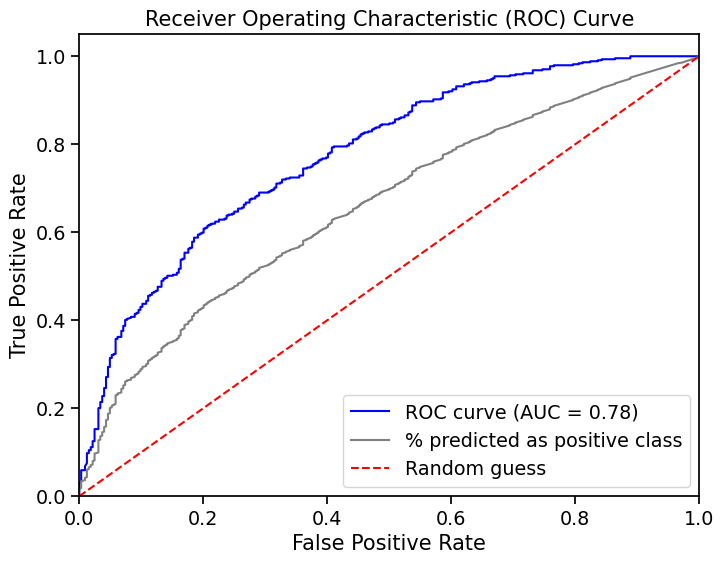

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 3.21 s, sys: 962 ms, total: 4.17 s
Wall time: 2.45 s


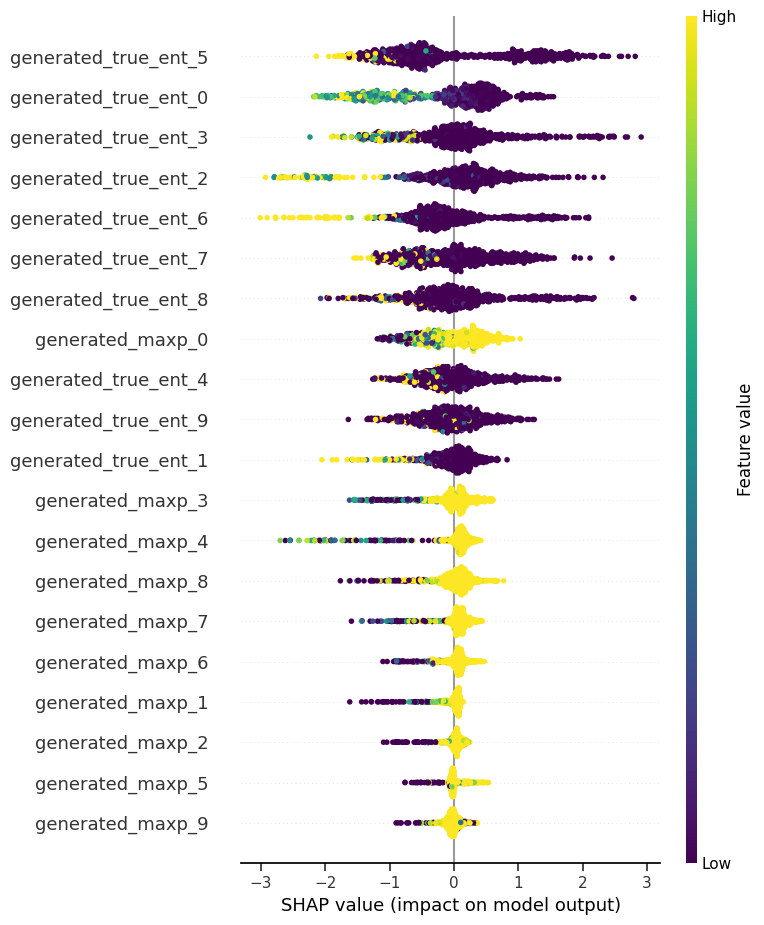

In [23]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [24]:
# shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [25]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [26]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [27]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.248042
generated_shape_       0.005569
generated_true_ent_    0.746389
Name: value, dtype: float64

In [28]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [29]:
vals

,label,value,label_orig,grp
15,5,0.126735,generated_true_ent_5,generated_true_ent_
10,0,0.092076,generated_true_ent_0,generated_true_ent_
13,3,0.080171,generated_true_ent_3,generated_true_ent_
12,2,0.080158,generated_true_ent_2,generated_true_ent_
16,6,0.077485,generated_true_ent_6,generated_true_ent_
17,7,0.075896,generated_true_ent_7,generated_true_ent_
18,8,0.074704,generated_true_ent_8,generated_true_ent_
20,0,0.054387,generated_maxp_0,generated_maxp_
14,4,0.052938,generated_true_ent_4,generated_true_ent_
19,9,0.050745,generated_true_ent_9,generated_true_ent_




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

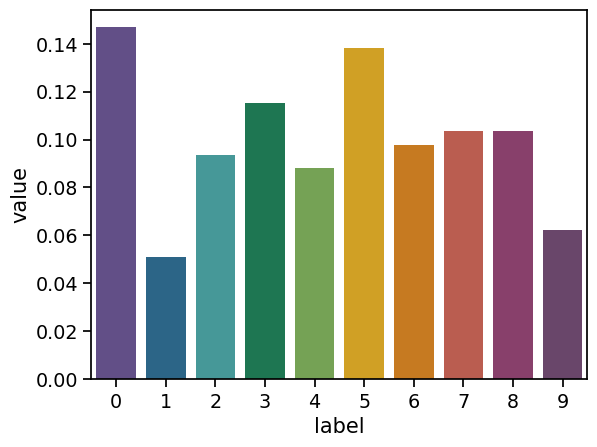

In [30]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

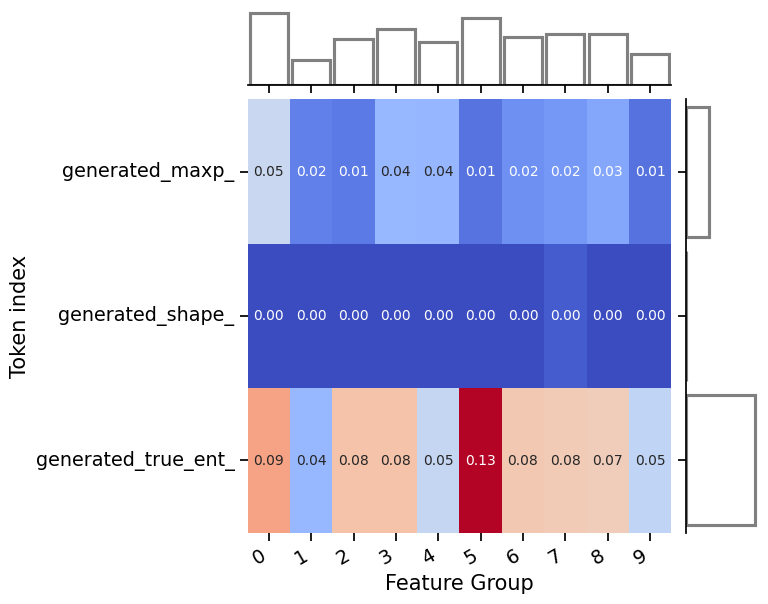

In [31]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### generated with all features

In [32]:
%%time

# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 220 ms, sys: 20.3 ms, total: 240 ms
Wall time: 108 ms


In [33]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_all = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 1min 7s, sys: 13.3 s, total: 1min 20s
Wall time: 17.5 s


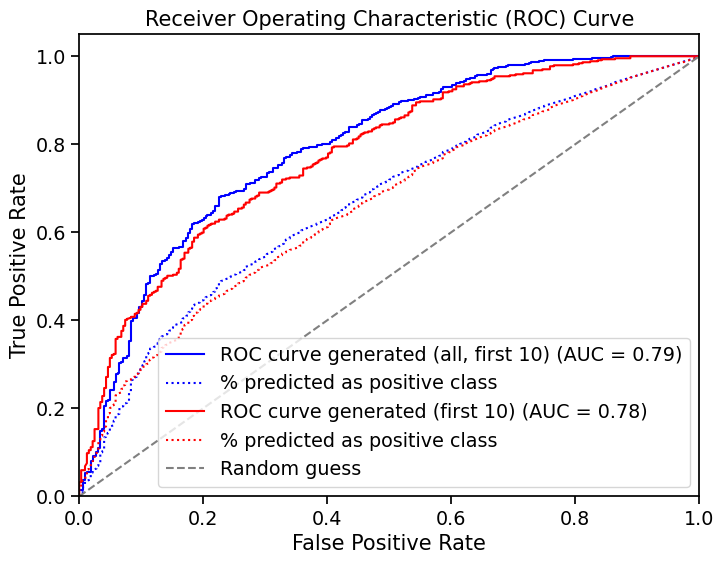

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_all[:, 1])
true_counts_rel = [(pred_proba_all[:, 1] > thr).sum() / pred_proba_all.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve generated (all, first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

CPU times: user 5.02 s, sys: 1.34 s, total: 6.37 s
Wall time: 2.47 s


grp
generated_logitlens_iou_    0.407586
generated_logitlens_kl_     0.451345
generated_maxp_             0.049859
generated_true_ent_         0.091211
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

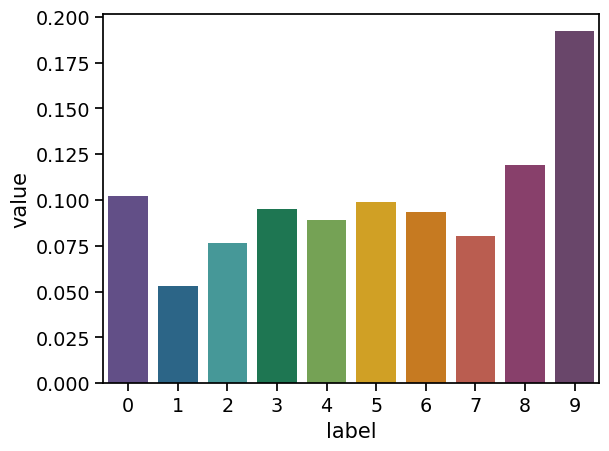

In [36]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

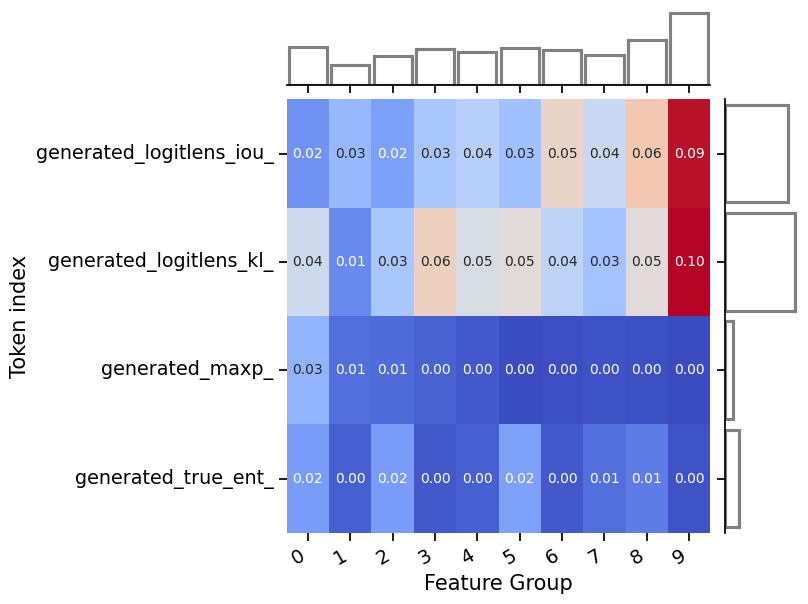

In [37]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [38]:
%%time

# beginning of generation
N = 10

selected_features = list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 159 ms, sys: 8.12 ms, total: 167 ms
Wall time: 54.9 ms


In [39]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [40]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

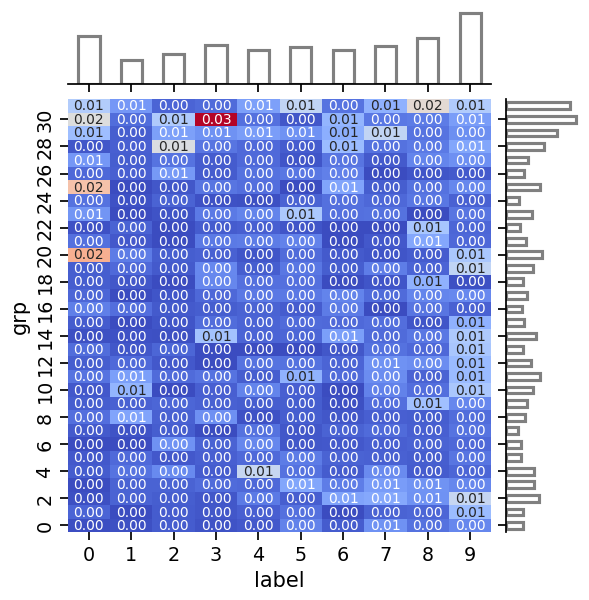

In [41]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

### postilla

In [42]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [43]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]
y_res_postilla = y_res

X_res.columns = ['postilla_'+col for col in X.columns]

In [44]:
ds

,run,pid,shape-65,shape-64,shape-63,shape-62,shape-61,shape-60,shape-59,shape-58,shape-57,shape-56,shape-55,shape-54,shape-53,shape-52,shape-51,shape-50,shape-49,shape-48,shape-47,shape-46,shape-45,shape-44,shape-43,shape-42,shape-41,shape-40,shape-39,shape-38,shape-37,shape-36,shape-35,shape-34,shape-33,shape-32,shape-31,shape-30,shape-29,shape-28,shape-27,shape-26,shape-25,shape-24,shape-23,shape-22,shape-21,shape-20,shape-19,shape-18,shape-17,shape-16,shape-15,shape-14,shape-13,shape-12,shape-11,shape-10,shape-9,shape-8,shape-7,shape-6,shape-5,shape-4,shape-3,shape-2,shape-1,maxp-65,maxp-64,maxp-63,maxp-62,maxp-61,maxp-60,maxp-59,maxp-58,maxp-57,maxp-56,maxp-55,maxp-54,maxp-53,maxp-52,maxp-51,maxp-50,maxp-49,maxp-48,maxp-47,maxp-46,maxp-45,maxp-44,maxp-43,maxp-42,maxp-41,maxp-40,maxp-39,maxp-38,maxp-37,maxp-36,maxp-35,maxp-34,maxp-33,maxp-32,maxp-31,maxp-30,maxp-29,maxp-28,maxp-27,maxp-26,maxp-25,maxp-24,maxp-23,maxp-22,maxp-21,maxp-20,maxp-19,maxp-18,maxp-17,maxp-16,maxp-15,maxp-14,maxp-13,maxp-12,maxp-11,maxp-10,maxp-9,maxp-8,maxp-7,maxp-6,maxp-5,maxp-4,maxp-3,maxp-2,maxp-1,true_ent-65,true_ent-64,true_ent-63,true_ent-62,true_ent-61,true_ent-60,true_ent-59,true_ent-58,true_ent-57,true_ent-56,true_ent-55,true_ent-54,true_ent-53,true_ent-52,true_ent-51,true_ent-50,true_ent-49,true_ent-48,true_ent-47,true_ent-46,true_ent-45,true_ent-44,true_ent-43,true_ent-42,true_ent-41,true_ent-40,true_ent-39,true_ent-38,true_ent-37,true_ent-36,true_ent-35,true_ent-34,true_ent-33,true_ent-32,true_ent-31,true_ent-30,true_ent-29,true_ent-28,true_ent-27,true_ent-26,true_ent-25,true_ent-24,true_ent-23,true_ent-22,true_ent-21,true_ent-20,true_ent-19,true_ent-18,true_ent-17,true_ent-16,true_ent-15,true_ent-14,true_ent-13,true_ent-12,true_ent-11,true_ent-10,true_ent-9,true_ent-8,true_ent-7,true_ent-6,true_ent-5,true_ent-4,true_ent-3,true_ent-2,true_ent-1,correct,hallucinated
0,0,12,5.0,5.0,18.0,14.0,9.0,3.0,3.0,95.0,6.0,1.0,3.0,1.0,3.0,5.0,11.0,140.0,2.0,2.0,1.0,16.0,2.0,2.0,1.0,27.0,6.0,1.0,1.0,2.0,1.0,7.0,3.0,1.0,18.0,4.0,1.0,2.0,1.0,1.0,1.0,3.0,66.0,1.0,1.0,11.0,14.0,1.0,8.0,47.0,4.0,2.0,1.0,2.0,39.0,156.0,1.0,1.0,5.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.478516,0.402344,0.464844,0.320312,0.453125,0.722656,0.808594,0.257812,0.597656,1.0,0.539062,0.960938,0.750000,0.468750,0.246094,0.088867,0.699219,0.855469,0.960938,0.296875,0.808594,0.851562,0.898438,0.250000,0.312500,1.000000,1.0,0.875000,0.996094,0.632812,0.652344,0.925781,0.378906,0.578125,1.000000,0.687500,0.906250,0.992188,0.992188,0.816406,0.345703,0.960938,0.988281,0.628906,0.398438,0.910156,0.253906,0.206055,0.601562,0.777344,1.0,0.785156,0.394531,0.439453,0.921875,1.0,0.757812,0.314453,1.000000,0.941406,0.953125,1.0,0.929688,1.0,1.000000,1.855949,1.743505,2.512197,2.554594,1.949440,1.076577,1.088586,3.736692,1.666185,0.004145,1.070491,0.270808,1.048249,1.673855,2.531380,4.644208,0.791852,0.693352,0.230593,2.545720,0.544832,0.756725,0.618709,2.811605,2.077665,0.013348,0.000025,0.568673,0.033008,1.671328,1.128419,0.337574,2.572449,1.220625,0.003342,1.067380,0.546967,0.056375,0.061368,0.815557,3.293175,0.215599,0.081678,1.945607,2.472231,0.387513,2.266762,3.377324,1.385153,0.534737,0.000015,0.608655,2.986983,3.501091,0.281217,0.000174,1.370518,2.603331,0.005834,0.329774,0.273930,0.000197,0.280745,0.000010,1.229896e-06,False,False
1,0,14,13.0,5.0,29.0,14.0,6.0,1.0,7.0,23.0,5.0,1.0,3.0,1.0,4.0,5.0,9.0,104.0,2.0,3.0,1.0,32.0,2.0,1.0,2.0,33.0,6.0,1.0,1.0,1.0,1.0,7.0,3.0,1.0,11.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,53.0,1.0,1.0,21.0,26.0,2.0,8.0,44.0,2.0,2.0,1.0,1.0,18.0,112.0,2.0,1.0,4.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.298828,0.486328,0.291016,0.357422,0.376953,0.941406,0.742188,0.355469,0.632812,1.0,0.425781,0.953125,0.400391,0.550781,0.330078,0.170898,0.660156,0.511719,0.914062,0.194336,0.824219,0.988281,0.871094,0.347656,0.400391,1.000000,1.0,0.933594,0.992188,0.699219,0.589844,0.914062,0.251953,0.609375,1.000000,0.792969,0.921875,0.980469,0.980469,0.695312,0.263672,0.898438,0.980469,0.535156,0.

In [45]:
y_res_postilla.shape, y_res_generated.shape

((512,), (763,))

In [46]:
%%time

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 10.8 s, sys: 4.71 s, total: 15.6 s
Wall time: 3.92 s


In [47]:
pred = pred_proba_postilla.argmax(axis=1).astype(bool)
print(classification_report(y_res_postilla.values, pred))

              precision    recall  f1-score   support

       False       0.33      0.27      0.30       145
        True       0.73      0.79      0.76       367

    accuracy                           0.64       512
   macro avg       0.53      0.53      0.53       512
weighted avg       0.62      0.64      0.63       512



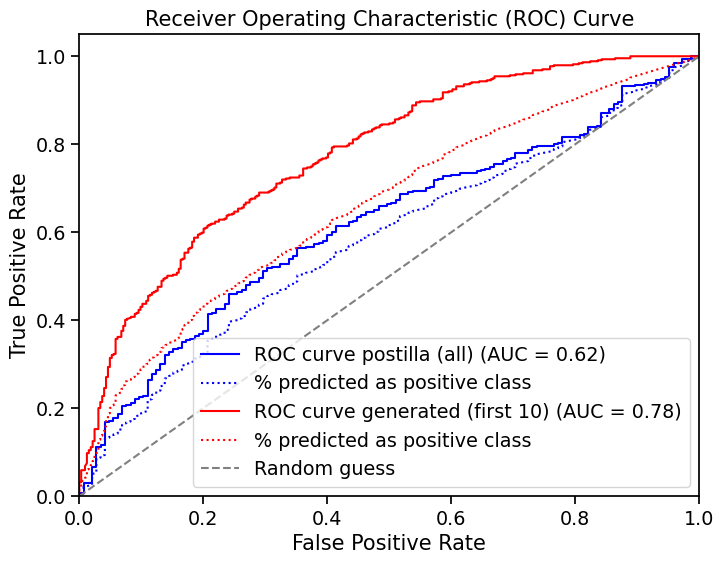

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [49]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

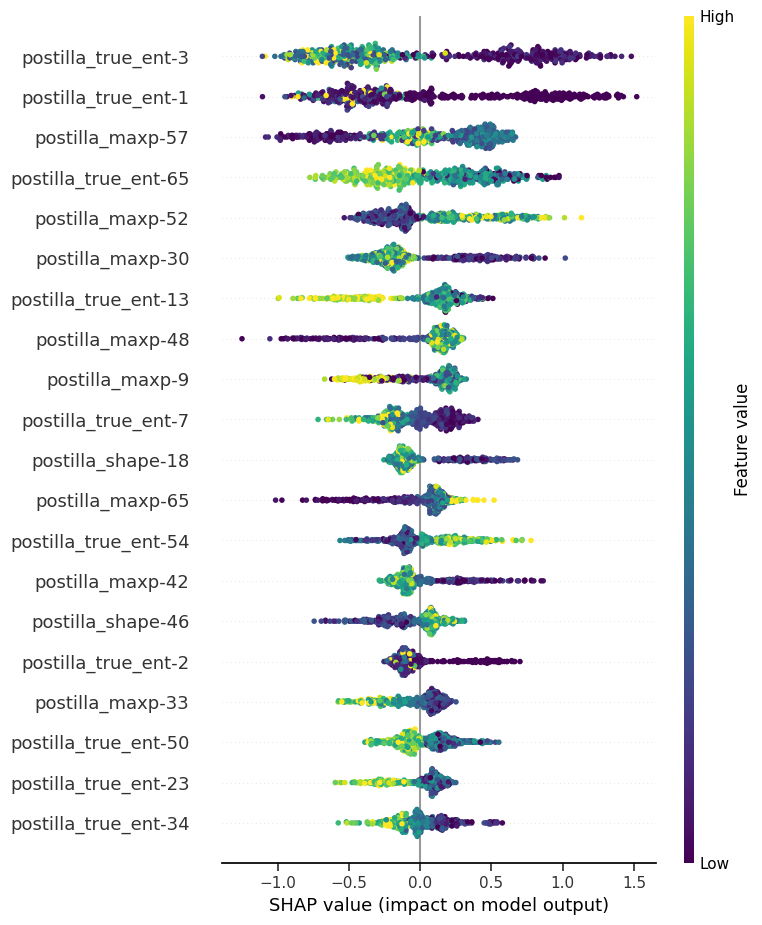

In [50]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [51]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [52]:
K = 10
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [53]:
vals.sort_values('value', ascending=False)[:K].value.sum()

0.2870124143801406

In [54]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.364344
postilla_shape-       0.118726
postilla_true_ent-    0.516930
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



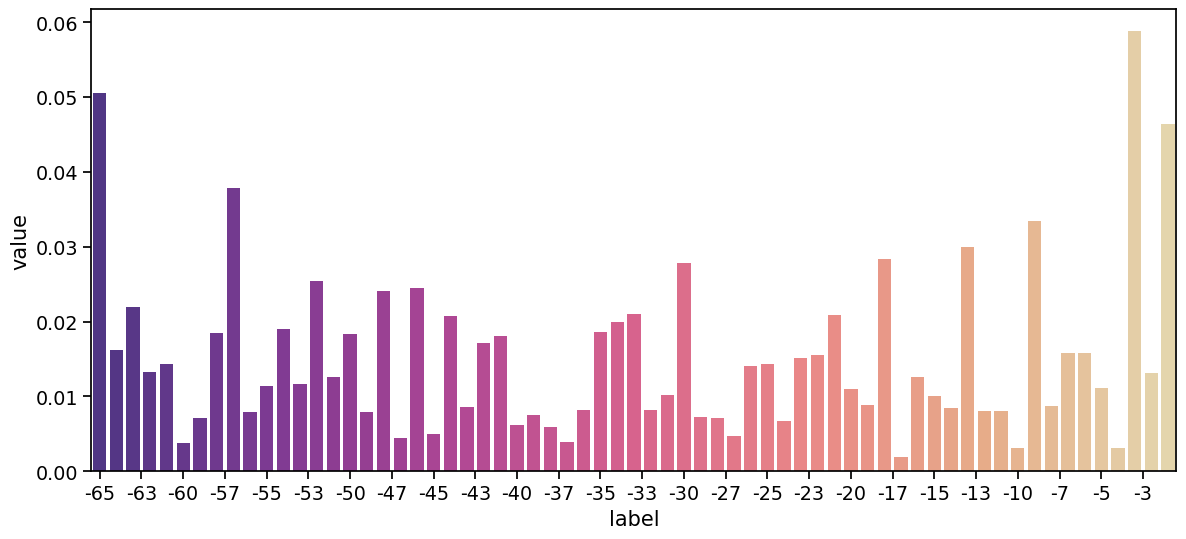

In [55]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

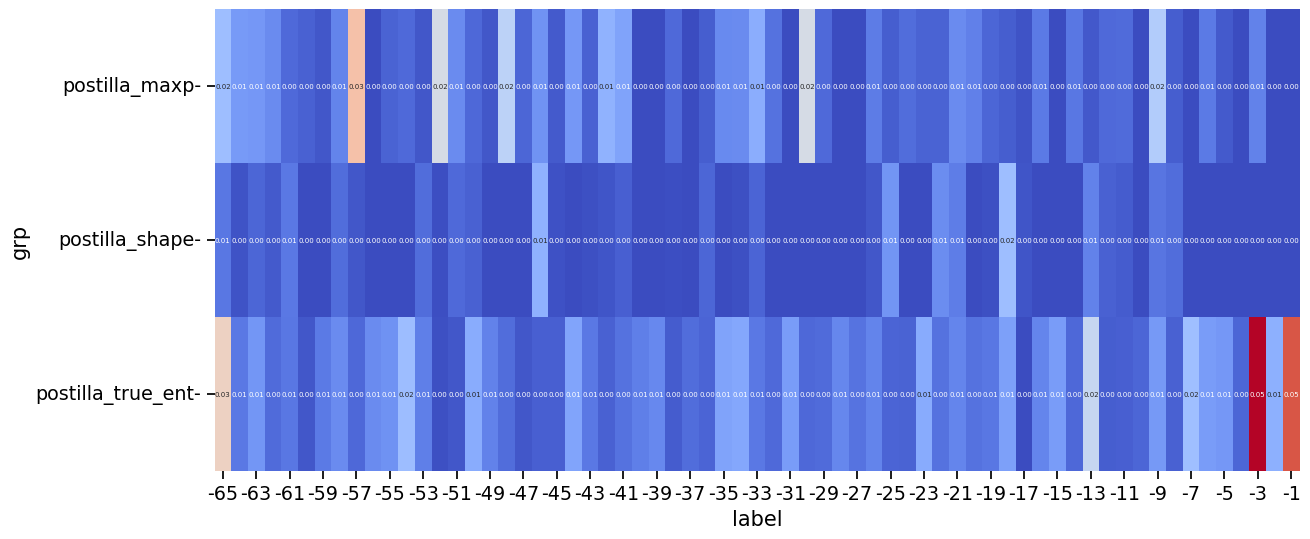

In [56]:
plt.figure(figsize=(14, 6))
_toplot = vals.pivot(index='grp', columns='label', values='value')
ax = plt.gca()
sns.heatmap(_toplot, ax=ax, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":5}, cmap="coolwarm")
plt.show()

### combo

In [57]:
# COMBO
# beginning of generate + postilla

ds = mm[(mm.segment=='generated') & (mm.tokzero<=N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [58]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [59]:
ds.shape, ds1.shape, ds2.shape

((5120, 232), (5120, 37), (5120, 199))

In [60]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELECT TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [61]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 4.52 s, sys: 2.93 s, total: 7.45 s
Wall time: 2.07 s


In [62]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.64      0.51      0.57      1418
        True       0.59      0.71      0.65      1418

    accuracy                           0.61      2836
   macro avg       0.62      0.61      0.61      2836
weighted avg       0.62      0.61      0.61      2836



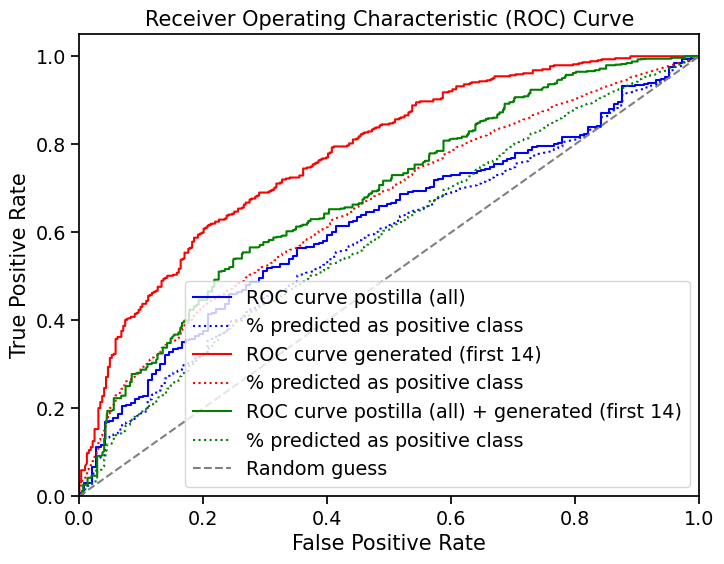

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [64]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [65]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [66]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.065602
generated_true_ent_    0.612932
postilla_maxp-         0.160455
postilla_true_ent-     0.161011
Name: value, dtype: float64

In [67]:
vals

,label,value,label_orig,grp
10,5,0.104639,generated_true_ent_5,generated_true_ent_
12,3,0.081924,generated_true_ent_3,generated_true_ent_
14,6,0.075592,generated_true_ent_6,generated_true_ent_
16,8,0.068176,generated_true_ent_8,generated_true_ent_
15,7,0.066283,generated_true_ent_7,generated_true_ent_
17,0,0.065602,generated_maxp_0,generated_maxp_
18,4,0.062669,generated_true_ent_4,generated_true_ent_
13,2,0.055395,generated_true_ent_2,generated_true_ent_
11,0,0.053494,generated_true_ent_0,generated_true_ent_
1,-1,0.051721,postilla_true_ent-1,postilla_true_ent-




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

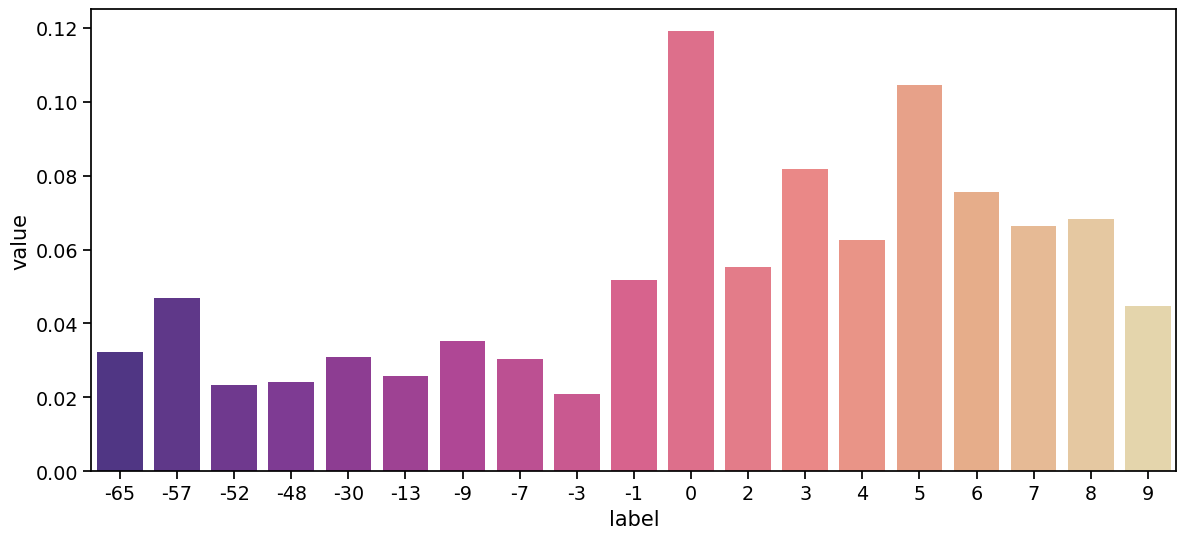

In [68]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

Text(27.44444444444443, 0.5, 'Token index')

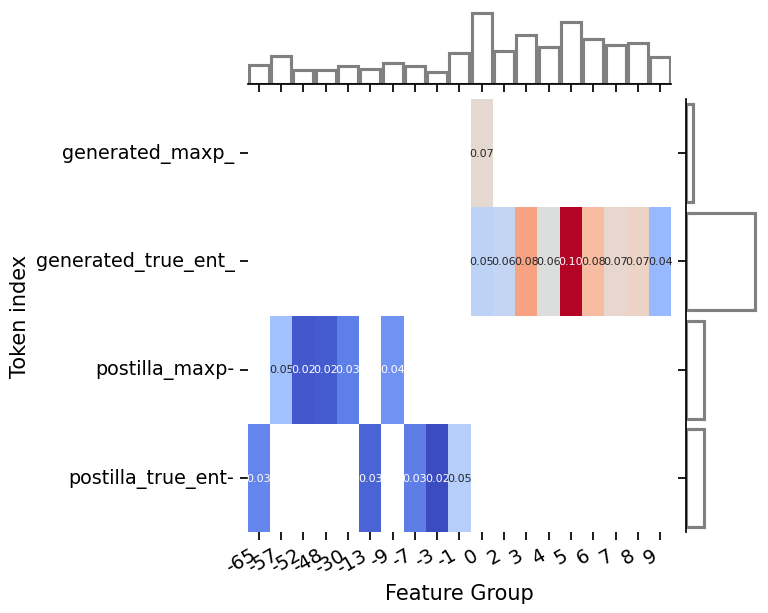

In [69]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":8}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of input (no candidates provided yet)

In [70]:
# end of input (last NN)
NN = 64
ds = mm[(mm.segment=='input') & (mm.tokzero_end>=-NN)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['input_'+col for col in X.columns]

In [71]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_input = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_input.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.53      0.30      0.38      1418
        True       0.51      0.74      0.61      1418

    accuracy                           0.52      2836
   macro avg       0.52      0.52      0.49      2836
weighted avg       0.52      0.52      0.49      2836

CPU times: user 14.9 s, sys: 4.89 s, total: 19.8 s
Wall time: 5.84 s


In [115]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

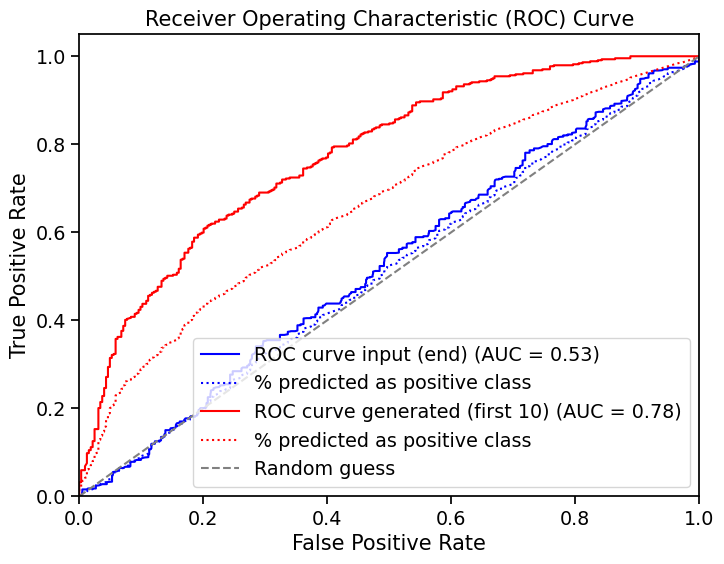

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_input[:, 1])
true_counts_rel = [(pred_proba_input[:, 1] > thr).sum() / pred_proba_input.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve input (end) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### does adding candidate distance measures add information?

In [73]:
# candidate measures are known at runtime and constant for each prompt

In [74]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [75]:
N = 2
#ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way?

In [76]:
# % of prompts showing variance in output across runs (selected features)
(ds.groupby('pid').std() != 0.).sum() / ds.pid.nunique()

run             1.000000
maxp0           0.000000
maxp1           0.000000
maxp2           0.000000
maxp3           0.000000
                  ...   
true_ent62      0.000000
true_ent63      0.000000
true_ent64      0.000000
correct         0.352227
hallucinated    0.018219
Length: 133, dtype: float64

In [77]:
# WARNING only unique observations
ds = ds.drop_duplicates(ds.columns[1:-2])

In [78]:
ds.shape

(494, 134)

In [79]:
ds.correct.value_counts()

correct
True     350
False    144
Name: count, dtype: int64

In [80]:
# check variances

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)

In [81]:
X_res.shape

(494, 132)

In [82]:
y_res.value_counts()

correct
True     350
False    144
Name: count, dtype: int64

In [83]:
(X_res.groupby('pid').std() != 0.).sum() / X_res.pid.nunique()

maxp0         1.0
maxp1         1.0
maxp2         1.0
maxp3         1.0
maxp4         1.0
             ... 
true_ent61    1.0
true_ent62    1.0
true_ent63    1.0
true_ent64    1.0
correct       1.0
Length: 131, dtype: float64

In [84]:
# dataset 

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(494, 130) 350


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent55', 'generated_true_ent56', 'generated_true_ent57',
       'generated_true_ent58', 'generated_true_ent59', 'generated_true_ent60',
       'generated_true_ent61', 'generated_true_ent62', 'generated_true_ent63',
       'generated_true_ent64'],
      dtype='object', length=130)

In [85]:
X_res.shape, y_res.shape

((494, 130), (494,))

In [86]:
# class weights
class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

In [87]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.41      0.31      0.35       144
        True       0.74      0.82      0.78       350

    accuracy                           0.67       494
   macro avg       0.57      0.56      0.56       494
weighted avg       0.64      0.67      0.65       494

CPU times: user 9.58 s, sys: 4.14 s, total: 13.7 s
Wall time: 3.58 s


In [88]:
# dataset with candidate measures

add = aggrodue[['pid', 'cand_average_dist_mean', 'cand_max_dist_mean', 'cand_average_jaccard_dist_mean', 'cand_average_jaccard_tok_dist_mean']]
add = add.rename(columns={'cand_average_dist_mean': 'cand_average_dist_mean999', 
                          'cand_max_dist_mean': 'cand_max_dist_mean999', 
                          'cand_average_jaccard_dist_mean': 'cand_average_jaccard_dist_mean999',
                          'cand_average_jaccard_tok_dist_mean': 'cand_average_jaccard_tok_dist_mean999'})
ds_ = ds.merge(add, on='pid')

y = ds_.correct
pids = ds_.pid
X = ds_.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(494, 134) 350


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent59', 'generated_true_ent60', 'generated_true_ent61',
       'generated_true_ent62', 'generated_true_ent63', 'generated_true_ent64',
       'generated_cand_average_dist_mean999',
       'generated_cand_max_dist_mean999',
       'generated_cand_average_jaccard_dist_mean999',
       'generated_cand_average_jaccard_tok_dist_mean999'],
      dtype='object', length=134)

In [89]:
X_res.shape, y_res.shape

((494, 134), (494,))

In [90]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba2 = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred2 = pred_proba2.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred2))

              precision    recall  f1-score   support

       False       0.40      0.31      0.35       144
        True       0.74      0.81      0.77       350

    accuracy                           0.66       494
   macro avg       0.57      0.56      0.56       494
weighted avg       0.64      0.66      0.65       494

CPU times: user 9.91 s, sys: 4.11 s, total: 14 s
Wall time: 3.9 s


In [91]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res, sample_weight=sample_weights)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [92]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (10) than needed (66) and will cycle, which may produce an uninterpretable plot.


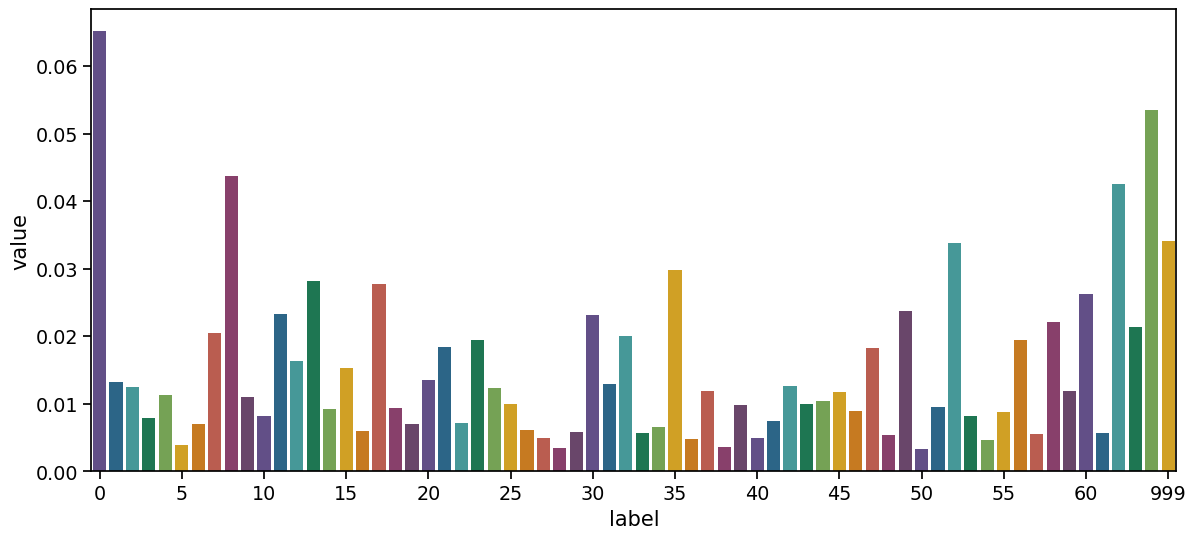

In [93]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

plt.figure(figsize=(14, 6))
ax = plt.gca()
sns.barplot(index_importances, palette=palette,ax=ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=16))

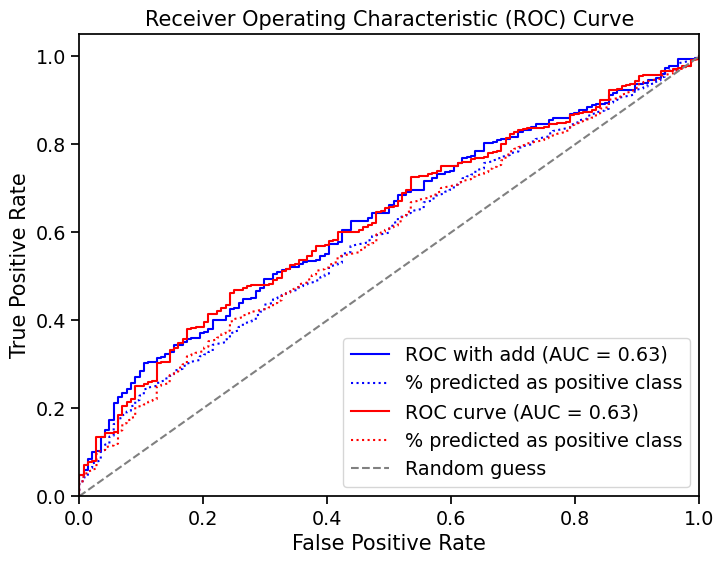

In [94]:
# compare with and without candidate measures

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba2[:, 1])
true_counts_rel = [(pred_proba2[:, 1] > thr).sum() / pred_proba2.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC with add (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### variable window generated

In [95]:
mm[mm.segment=='generated'].groupby('pid').tokzero.max().min()

13

In [96]:
%%time

outs_generated = []

for K in range(0, mm[mm.segment=='generated'].groupby('pid').tokzero.max().min()+1, 1):
    print(K, end='\r')
    ds = mm[(mm.segment=='generated') & (mm.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated.append((r, K, pred_proba, y_res))

CPU times: user 3min 22s, sys: 2min 36s, total: 5min 58s
Wall time: 1min 39s


In [97]:
%%time

outs_generated_kl = []

selected_features = list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)

for K in range(0, mmg.groupby('pid').tokzero.max().min()+1, 1):
    print(K, end='\r')
    ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated_kl.append((r, K, pred_proba, y_res))

CPU times: user 38min 52s, sys: 10min 18s, total: 49min 10s
Wall time: 11min 33s


In [98]:
# generated with entropy/maxp features

aucs = []
for r, K, pred_proba, y_res in outs_generated:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_1 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_1['src'] = 'entropy/maxp'


# generated with kl/iou
aucs = []
for r, K, pred_proba, y_res in outs_generated_kl:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_2 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_2['src'] = 'kl/iou'

# aucs_ = pd.concat([aucs_1, aucs_2], axis=1)

#from scipy.ndimage import gaussian_filter1d
#aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

#sns.lineplot(aucs_, x='k', y='auc').set_title("AUC generated 1>14")
#plt.show()

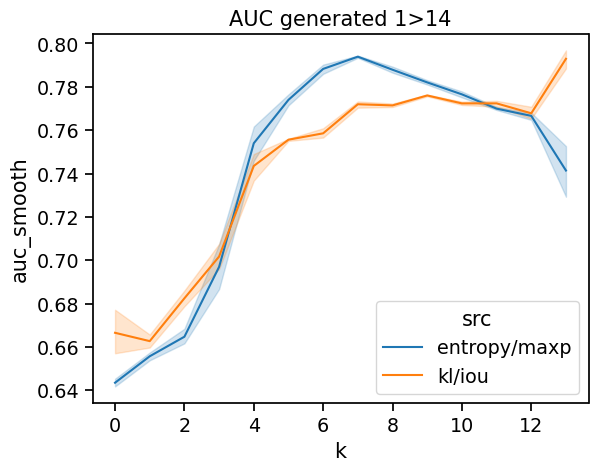

In [99]:
aucs_ = pd.concat([aucs_1, aucs_2], axis=0)

from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

sns.lineplot(aucs_, x='k', y='auc_smooth', hue='src').set_title("AUC generated 1>14")
plt.show()

### variable windows postilla

In [100]:
mm[mm.segment=='postilla'].tokzero.max()

64

In [106]:
%%time

outs_postilla = []

for K in range(0, mm[mm.segment=='postilla'].tokzero.max()+1, 2):
    print(K, end='\r')
    ds = mm[(mm.segment=='postilla') & (mm.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way? 
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res, pids_res = X, y, pids
        X_res.columns = ['generated_'+col for col in X.columns]
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_postilla.append((r, K, pred_proba, y_res))

CPU times: user 43min 26s, sys: 12min 10s, total: 55min 36s
Wall time: 48min 39s


In [107]:
aucs = []
for r, K, pred_proba, y_res in outs_postilla:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))

In [108]:
aucs_ = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])

In [109]:
aucs_

,r,k,auc
0,0,0,0.516667
1,1,0,0.520853
2,2,0,0.525933
3,3,0,0.519603
4,4,0,0.517401
...,...,...,...
259,3,64,0.640417
260,4,64,0.632679
261,5,64,0.627500
262,6,64,0.639087


In [110]:
from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

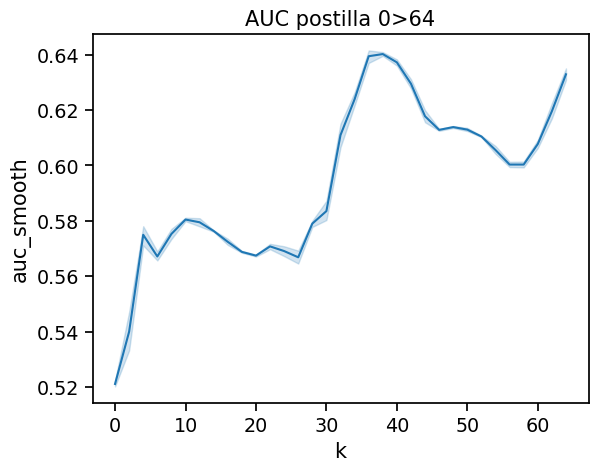

In [111]:
# postilla
sns.lineplot(aucs_, x='k', y='auc_smooth').set_title("AUC postilla 0>64")
plt.show()

In [112]:
%%time

outs_question = []

for K in range(-1, -128, -16):
    print(K, end='\r')
    ds = mm[(mm.segment=='question') & (mm.tokzero_end>=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way? 
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(1):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_question.append((r, K, pred_proba, y_res))

CPU times: user 7min, sys: 2min 23s, total: 9min 23s
Wall time: 10min 18s


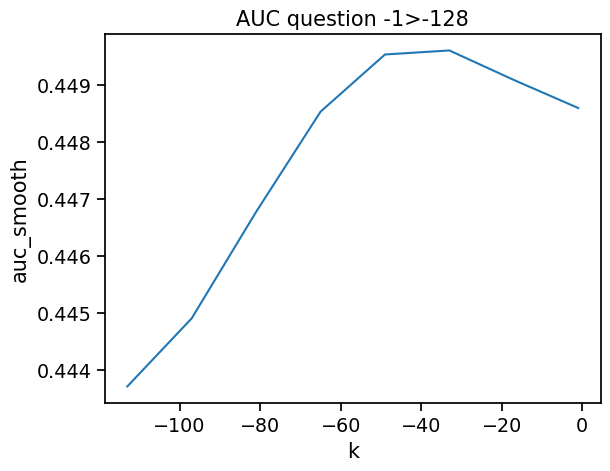

In [113]:
# end of question (reverse order)

aucs = []
for r, K, pred_proba, y_res in outs_question:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_ = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

sns.lineplot(aucs_, x='k', y='auc_smooth').set_title("AUC question -1>-128")
plt.show()